In [79]:
#导入需要的库
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
%matplotlib inline

In [80]:
#读取数据
aural = np.load(r'data/mod_aural.npy')
social = np.load(r'data/mod_social.npy')
textual = np.load(r'data/mod_textual.npy')
visual = np.load(r'data/mod_visual.npy')
train = np.load(r'data/train.npy')
#训练数据
aural_train = aural[:1600,:]
social_train = social[:1600,:]
textual_train = textual[:1600,:]
visual_train = visual[:1600,:]
#测试数据
aural_test = aural[1600:,:]
social_test = social[1600:,:]
textual_test = textual[1600:,:]
visual_test = visual[1600:,:]

In [81]:
#GPU
use_gpu = torch.cuda.is_available()

In [82]:
#精度
'''
nn.benchmark = False            # if benchmark=True, deterministic will be False
nn.deterministic = True
'''
seed = 1
torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed) 

random.seed(seed)
np.random.seed(seed)

# 尝试做一元线性回归
Y = WX + B
# L_250 nMSE=1.0133133653858664	
 L_500 nMSE=1.0133146432026512	
 L_1000 nMSE=1.0133162861099463		

In [83]:
#连接数据
linear_train = np.concatenate([aural_train, social_train,textual_train,visual_train], 1)
linear_test = np.concatenate([aural_test,social_test,textual_test,visual_test],1)

m = linear_train.shape[0]
n0 = linear_train.shape[1]
nL = int(train.size/m)


In [84]:
iterate = 1000
nH = nL
class LRnet(nn.Module):
    """
    Linear Regressoin Module, the input features and output 
    features are defaults both 1
    """
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(n0,nH)
        self.predict = nn.Linear(nH,nL) 
    
    def forward(self,x):
        x = nn.functional.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [85]:
net = LRnet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()
if(use_gpu):
    net = net.cuda()
    loss_func = loss_func.cuda()

In [86]:
data = {'x':torch.from_numpy(linear_train),'y':torch.from_numpy(train)}
if (use_gpu):
    data['x'],data['y'] = data['x'].cuda(),data['y'].cuda()

In [87]:

for t in range(iterate):
    prediction = net(data['x'])
    loss = loss_func(prediction, data['y'])     # must be (1. nn output, 2. target)
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if((t+1)%50 ==0):
        print(t+1,loss)

50 tensor(1.0153, device='cuda:0', grad_fn=<MseLossBackward>)
100 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
150 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
200 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
250 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
300 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
350 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
400 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
450 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
500 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
550 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
600 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
650 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
700 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
750 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
800 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBack

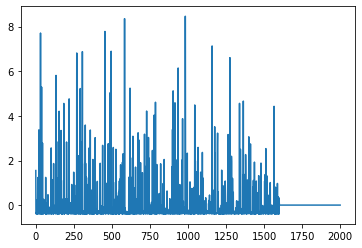

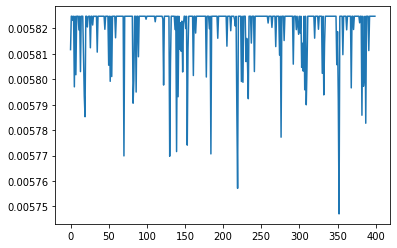

In [88]:
if(use_gpu):
    net = net.cpu()
predict = net(torch.from_numpy(linear_test))    
pre = predict.detach().numpy().flatten()
total = np.concatenate([train,pre])
x = range(total.shape[0])
y = total[x]
plt.plot(x,y)
plt.show()
x = range(pre.shape[0])
y = pre[x]
plt.plot(x,y)
plt.show()
np.save(r'prediction/L_'+str(iterate)+'.npy',pre)
# L_500 nMSE=1.0133146432026512	
# L_1000 nMSE=1.0133162861099463

# 加入一次主成分分析
PCA_50_L_250 nMSE=1.0133798118586848	
PCA_50_L_500 nMSE=1.01336904168864
PCA_75_L_500 nMSE=1.01325851053674	
# PCA_100_L_500 nMSE=1.0130263129723853
PCA_100_L_1000 nMSE=1.0130448413157673	
PCA_150_L_500 nMSE=1.0136613879145158	

In [89]:
#主成分分析
def pca(X,n):
    """
    input:矩阵X,每一行一条训练数据
    return:投影矩阵（按照维度的重要性排序）、方差和均值
    """
    #获取维数
    num_data,dim = X.shape
    print(num_data,dim)

    #数据中心化:因为数据是按行保存的
    mean_X = X.mean(axis=0)
    X = np.subtract(X, mean_X)
    #pca使用SVD方法
    U,S,V = np.linalg.svd(X)
    #返回前n维的数据
    U = U[:,:n]
        
    #返回投影矩阵、方差和均值
    return U

In [90]:
n0 = 100
nL = 1
nH = nL
iterate = 1000
class PCALRnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(n0,nH)
        self.predict = nn.Linear(nH,nL) 
    
    def forward(self,x):
        x = nn.functional.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [91]:
net = PCALRnet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()
if(use_gpu):
    net = net.cuda()
    loss_func = loss_func.cuda()

In [92]:
PCA_tmp = pca(linear_train,n0)
PCA_train = torch.from_numpy(np.array(PCA_tmp,dtype = float)).float()
PCA_tmp =pca(linear_test,n0)
PCA_test = torch.from_numpy(np.array(PCA_tmp,dtype = float)).float()

1600 279
400 279


In [93]:
if (use_gpu):
    PCA_train = PCA_train.cuda()
for t in range(iterate):
    prediction = net(PCA_train)
    loss = loss_func(prediction, data['y'])     # must be (1. nn output, 2. target)
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if((t+1)%10 == 0):
        print(t+1,loss)

10 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
20 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
30 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
40 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
50 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
60 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
70 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
80 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
90 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
100 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
110 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
120 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
130 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
140 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
150 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
160 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
1

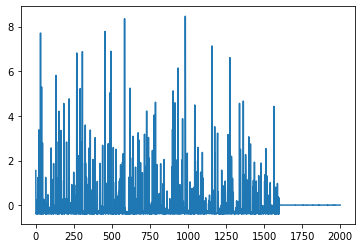

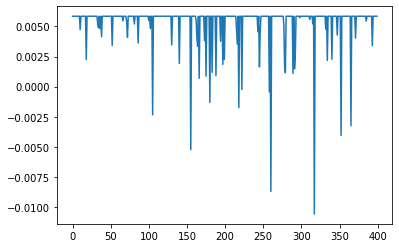

In [94]:
if(use_gpu):
    net = net.cpu()
    PCA_test = PCA_test.cpu()
predict = net(PCA_test)    
pre = predict.detach().numpy().flatten()
total = np.concatenate([train,pre])
x = range(total.shape[0])
y = total[x]
plt.plot(x,y)
plt.show()
x = range(pre.shape[0])
y = pre[x]
plt.plot(x,y)
plt.show()
np.save(r'prediction/PCA_'+str(n0)+'_L_'+str(iterate)+'.npy',pre)

# 尝试deepcrossing
数值型特征跳过embedding层，只有social的d3是类别型特征

DC_sigmoid1000 nMSE=1.0116955580634657
DC_sigmoid10000 nMSE=1.0116924547941308
DC_sigmoid35000 1.0120108137188435
DC_sigmoid460000 1.013107089247721		


In [95]:
class Residual_block(nn.Module):
    """
    Define Residual_block
    """
    def __init__(self, hidden_unit, dim_stack):
        super(Residual_block, self).__init__()
        # 两个线性层   注意维度， 输出的时候和输入的那个维度一致， 这样才能保证后面的相加
        self.linear1 = nn.Linear(dim_stack, hidden_unit)
        self.linear2 = nn.Linear(hidden_unit, dim_stack)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        orig_x = x.clone()
        x = self.linear1(x)
        x = self.linear2(x)
        outputs = self.relu(x + orig_x)       # 跳远链接
        return outputs

In [96]:
class DeepCrossing(nn.Module):
    
    def __init__(self, dim_stack, hidden_units=3, dropout=0., output_dim=1):
        """
        DeepCrossing：
            stack:stacking的结果
        """
        super(DeepCrossing, self).__init__()
        
        # 残差层
        self.res_layers = nn.ModuleList([
            Residual_block(unit, dim_stack) for unit in range(1,hidden_units+1)
        ])
        
        # dropout层
        self.res_dropout = nn.Dropout(dropout)
        
        # 线性层
        self.linear = nn.Linear(dim_stack, output_dim)
    
    def forward(self, x):
        r = x
        for res in self.res_layers:
            r = res(r)
        
        r = self.res_dropout(r)
        outputs =  nn.functional.sigmoid(self.linear(r))
        return outputs

In [97]:
#embedding
sociald3 =  social_train[:,2]
embed = nn.Embedding(1600,10)
embed_sociald3 = embed(torch.from_numpy(sociald3).long())

sociald3t = social_test[:,2]
embed = nn.Embedding(400,10)
embed_sociald3t = embed(torch.from_numpy(sociald3t).long())
print(embed_sociald3t.shape)

torch.Size([400, 10])


In [98]:
#stacking
stack=np.concatenate([aural_train, social_train[:,:1],embed_sociald3.detach().numpy(),textual_train,visual_train], 1)
stack=torch.from_numpy(stack)
test = np.concatenate([aural_test,social_test[:,:1],embed_sociald3t.detach().numpy(),textual_test,visual_test],1)
print(test.shape)

(400, 287)


In [99]:
net = DeepCrossing(stack.shape[1])
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()
if(use_gpu):
    net = net.cuda()
    loss_func = loss_func.cuda()

In [100]:
iterate = 1000
if (use_gpu):
    stack = stack.cuda()
for t in range(iterate):
    prediction = net(stack)
    loss = loss_func(prediction, data['y'])     # must be (1. nn output, 2. target)
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if(t%500 == 0):
        print(t,loss)

0 tensor(1.3329, device='cuda:0', grad_fn=<MseLossBackward>)
500 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)


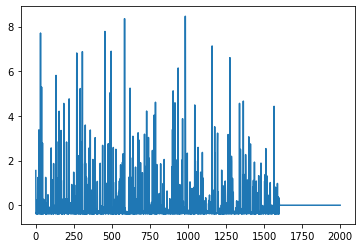

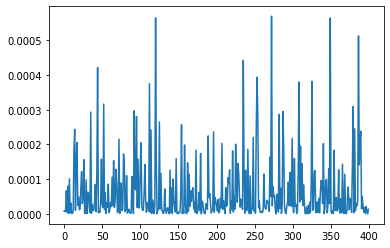

In [101]:
if(use_gpu):
    net = net.cpu()
predict = net(torch.from_numpy(test))    
pre = predict.detach().numpy().flatten()
total = np.concatenate([train,pre])
x = range(total.shape[0])
y = total[x]
plt.plot(x,y)
plt.show()
x = range(pre.shape[0])
y = pre[x]
plt.plot(x,y)
plt.show()
np.save(r'prediction/DC_sigmoid'+str(iterate)+'.npy',pre)

# 不做embedding
DC_no_embed_re3_sigmoid10000.npy
1.0116010908940054	

DC_no_embed_re3_drop0_sigmoid10000.npy
1.0117061456882555	

DC_no_embed_re3_drop0_sigmoid5000.npy
1.0117283249367375	

DC_no_embed_re3_drop0.2_sigmoid5000.npy
1.012055628578945	

DC_no_embed_re3_drop0.2_sigmoid7500.npy
1.0125558025776336	

DC_no_embed_re3_drop0.2_sigmoid10000.npy
1.012578620734508	

DC_no_embed_re3_drop0.3_sigmoid10000.npy
1.0119077669223984	

DC_no_embed_re3_drop0.2_sigmoid20000.npy
1.0122838101476899	

DC_no_embed_re9_drop0_sigmoid10000.npy
1.013020927887363

DC_no_embed_re9_drop0_sigmoid1000.npy
1.0117059631430005

DC_no_embed_re6_drop0_sigmoid1000.npy
1.0117059631430005

DC_no_embed_re6_drop.1_sigmoid10000.npy
1.0117059631430005

DC_no_embed_re6_drop0.2_sigmoid10000.npy
1.0117058718703729	

In [102]:
stack = torch.from_numpy(linear_train)
hidden_units = 3
dropout = 0
learning_rate = .2
net = DeepCrossing(stack.shape[1],hidden_units,dropout)
optimizer = torch.optim.SGD(net.parameters(), learning_rate)
loss_func = torch.nn.MSELoss()
if(use_gpu):
    net = net.cuda()
    loss_func = loss_func.cuda()

In [103]:
iterate = 10000
if (use_gpu):
    stack = stack.cuda()
for t in range(iterate):
    prediction = net(stack)
    loss = loss_func(prediction, data['y'])     # must be (1. nn output, 2. target)
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if(t%500 == 0):
        print(t,loss)

0 tensor(1.2570, device='cuda:0', grad_fn=<MseLossBackward>)
500 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
1000 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
1500 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
2000 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
2500 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
3000 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
3500 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
4000 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
4500 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
5000 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
5500 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
6000 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
6500 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
7000 tensor(1.0151, device='cuda:0', grad_fn=<MseLossBackward>)
7500 tensor(1.0151, device='cuda:0', grad_fn

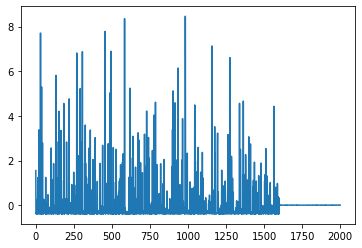

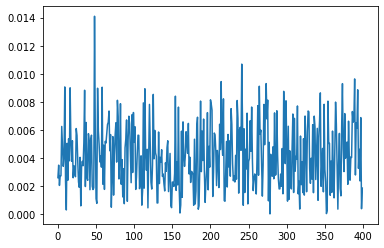

In [104]:
if(use_gpu):
    net = net.cpu()
predict = net(torch.from_numpy(linear_test))    
pre = predict.detach().numpy().flatten()
total = np.concatenate([train,pre])
x = range(total.shape[0])
y = total[x]
plt.plot(x,y)
plt.show()
x = range(pre.shape[0])
y = pre[x]
plt.plot(x,y)
plt.show()
np.save(r'prediction/DC_no_embed_re'+ str(hidden_units) +'_drop'+ str(dropout)+'_sigmoid'+str(iterate)+'.npy',pre)